$$\large{\mathbf{Instituto\ Superior\ de\ Engenharia\ de\ Lisboa}}$$

$$\large{\mathrm{Licenciatura\ em\ Engenharia\ Informática\ e\ Multimédia}}$$

$$\Large{\mathbf{Processamento\ de\ Imagem\ e\ Visão}}$$

$$\normalsize{\mathbf{2º\ Trabalho\ Prático\ B\\}}$$

$$\normalsize{\mathbf{Pedro\ Silva\ (48965)\\}}$$

# Introdução
<hr style="height:3px"/>

O presente relatório procura descrever o processo
de desenvolvimento do nosso projeto, que incide na
análise de sequências de imagens de um sistema de
vigilância procurando detetar zonas da imagem onde
ocorram movimentos e a partir destas objetos de interesse classificados como uma de três classes: pessoa,
carro ou outra.
Para o desenvolvimento do trabalho foi utilizada a
linguagem Python 3.9.7 com as bibliotecas datetime
(built-in), NumPy 1.20.3 e OpenCV 4.7.0.



O vídeo em estudo foi capturado a partir de uma
câmara de vigilância apontada para um entroncamento
com estacionamento, sendo que esta está colocada numa
posição alta, provavelmente debaixo do parapeito do
telhado de um prédio. O ambiente no vídeo está solarento o que, sem demasia (que é o caso), facilita as
operações a realizar. Ao longo da sequência é observada
uma pessoa que cruza a estrada para entrar num carro
estacionado, um carro que estaciona de onde sai uma
pessoa, quatro pessoas que atravessam a rua, a última
destas de bicicleta, e finalmente um carro que também
o faz.
Este vídeo tem uma duração de 2 minutos, 2 segundos
e 56 centésimos de segundo, e uma frame rate de
24.99184339314845, o que totaliza 3064 frames.


# 1. Pré-Processamento
## 1.1. Estimação de imagem de fundo
<hr style="height:3px"/>

Para detetarmos movimento numa imagem temos de ter uma imagem de fundo para ser usada
como base.

In [1]:
def get_frame(cap, idx):
    # check for valid frame number
    if idx >= 0 & idx <= cap.get(cv2.CAP_PROP_FRAME_COUNT):
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        flag, cap_img = cap.read()
        if flag:
            return cap_img


def estimate_bg_img(cap, samples, first_frame, last_frame):
    sample_idx = np.linspace(first_frame + 1, last_frame - 1, samples).astype(int)
    sample_frames = []
    for i in range(samples):
        sample_frames.append(get_frame(cap, sample_idx[i]))
    sample_frames = np.array(sample_frames)
    return np.median(sample_frames, axis=0).astype(np.uint8)

A função get_frame() vai capturar o vídeo no instante (na frame) dada como parâmetro.


A função estimate_bg_img() é responsável por criar/estimar uma imagem de fundo utilizando a
filtragem temporal com o filtro de mediana. Nesta função fornecemos o número de amostras e o
número da primeira e da última frame da captura que queremos para estimar uma imagem com
base num filtro de mediana temporal (pixel a pixel).

## 1.2. Atualização da imagem de fundo
<hr style="height:3px"/>

A imagem de fundo tem de ser renovada para atualizarmos as alterações que foram feitas (por
exemplo: na imagem de fundo temos um lugar de estacionamento vazio que no momento a seguir
é ocupado por um carro – movimento – e que termina a sua trajetória – fim do movimento).

In [2]:
def generate_bg_imgs(cap, n, samples, blurred, ini, fin):
    frame_count = cap.get(cv2.CAP_PROP_FRAME_COUNT)
    breakpoints = np.linspace(ini + 1, fin - 1, n + 1).astype(int)
    imgs = []
    for i in range(n):
        img = estimate_bg_img(cap, samples, breakpoints[i], breakpoints[i + 1])
        if blurred:
            img = cv2.GaussianBlur(img, (3, 3), 0)
        imgs.append(img)
    print('Images Generated:', n)
    cap.set(cv2.CAP_PROP_POS_FRAMES, 0)  # reset capture
    return np.array(imgs)

Nesta função geramos n imagens de fundo ao longo do vídeo (recorrendo ao método criado
anteriormente), usando o número de amostras (frames) fornecido que serão usadas em diferentes
momentos do vídeo (por ordem).

# 2. Processamento do Vídeo
<hr style="height:3px"/>

Vamos então começar a processar o vídeo e analisar cada frame, extraindo as suas características.

In [3]:
def Tracking(video0, ini, fin):
    cam = cv2.VideoCapture(video0)

    # frame inicial e final
    bg_ini = 0
    bg_fin = fin - ini
    final = []

    # Generate background images
    bgs = generate_bg_imgs(cam, 10, 15, True, bg_ini, bg_fin)

    cam.set(cv2.CAP_PROP_POS_FRAMES, ini)

    # Initializa centroides and trajectories
    centroids = np.zeros((1, 3)).astype(int)
    trajectories = np.array([-10, -10, fin - ini]).astype(int)

    # Play video from ini to fini
    while True:
        flag, cap_img = cam.read()
        if flag:
            frame = cam.get(cv2.CAP_PROP_POS_FRAMES)
            if frame > fin:
                break

            bg_idx = int((frame - ini) / (fin - ini) * len(bgs))
            print('frame:', int(frame), 'bg:', int(bg_idx))

            centroids, trajectories, tj = process(bgs[min(bg_idx, len(bgs) - 1)], cap_img, centroids, trajectories, debug=false)
            final.append(tj)

        key = cv2.waitKey(33)  # Press Esc to exit
        if key == 27:
            cv2.destroyAllWindows()
            cam.release()
            break

    cv2.destroyAllWindows()
    cam.release()
    
    return final

Nesta função fornecemos as imagens de fundo estimadas, que serão distribuídas e usadas durante
o vídeo por iguais períodos para fazermos a deteção de pixéis ativos.

## 2.1. Deteção de pixéis ativos
<hr style="height:3px"/>

In [4]:
def detectPixActive(bg_img_blur, cap_img):
    
    # Original Img
    # cv2.imshow('Background', bg_img_blur)
    # cv2.imshow('Original', cap_img)
    cap_img_blur = cv2.GaussianBlur(cap_img, (3, 3), 0)

    # Difference
    diff_n = cv2.subtract(bg_img_blur, cap_img_blur)  # pretos
    diff_p = cv2.subtract(cap_img_blur, bg_img_blur)  # brancos
    difference = np.bitwise_or(diff_n, diff_p)
    #cv2.imshow('Difference', difference)
    
    return difference

Nesta etapa a primeira coisa a fazer é aplicar um filtro gaussiano para suavizarmos a imagem para
facilitar na operação de subtração com a imagem de fundo (também suavizada).


Realizamos as duas subtrações para tomarmos partido dos valores mais altos da diferença das
imagens. Desta maneira, juntando os dois resultados com uma operação or, obtemos uma imagem
com os melhores valores.

## 2.2. Binarização e Operadores Morfológicos
<hr style="height:3px"/>

Para conseguirmos definir os contornos precisamos de trabalhar com uma imagem binária.

In [5]:
def binary(difference):
    
    # Gray
    gray = np.bitwise_or(np.bitwise_or(difference[:, :, 0], difference[:, :, 1]), difference[:, :, 2])
    # cv2.imshow('Gray', gray)

    # Binary 
    thres, bw = cv2.threshold(gray, 30, 255, cv2.THRESH_BINARY)  # manual threshold
    #cv2.imshow('Binary', bw)
    
    # Operadores Morfológicos
    str_elem = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (20, 20), (-1, -1))
    bw1 = cv2.morphologyEx(bw, cv2.MORPH_CLOSE, str_elem)
    str_elem = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5), (-1, -1))
    bw1 = cv2.morphologyEx(bw1, cv2.MORPH_OPEN, str_elem)
    
    return bw1

1º gray – temos de converter a imagem com os pixéis activos numa imagem
monocromática, para isso passamos as três componentes de cor por um operador or para
extrairmos a componente com o valor mais alto.


2º binarização – criamos um limiar que divide os valores dos pixéis para ignorarmos os
valores pequenos e ficarmos com uma imagem binária. Usamos um limiar manual e não
um automático (otsu) porque este limiar devolvia as alterações dos pixéis pequenos
(ruído) quando não há grandes valores dos pixéis activos.


3º operadores morfológicos – depois de termos a imagem binária aplicamos os operadores
morfológicos de fecho (dilatação seguida de uma erosão) e de abertura (erosão seguida
de dilatação) com um elemento estruturante mais pequeno para aperfeiçoar os resultados.

## 2.3. Extração de propriedades
<hr style="height:3px"/>

Depois de termos a imagem binária conseguimos calcular os contornos recorrendo à função
findContours() da biblioteca opencv, para depois podermos calcular a sua área e o seu hull.

In [6]:
def extractProp(bw1, cap_img):
    
    #contours 
    contours, hierarchy = cv2.findContours(bw1, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cont1 = cv2.drawContours(cap_img.copy(), contours, -1, (0, 0, 255), 3)
    #cv2.imshow('Contours', cont1)
    

    # Areas 
    areas = np.zeros(len(contours))
    for i in range(len(contours)):
        areas[i] = cv2.contourArea(contours[i])
    contours_idx = np.ravel(np.argwhere(areas > 40))

    # Hull
    hull = []
    for i in contours_idx:
        hull.append(cv2.convexHull(contours[i], False))
    hull1 = cv2.drawContours(cap_img.copy(), hull, -1, (0, 0, 0), 1, 8)
    # cv2.imshow('Hull', hull1)
    
    return contours, areas, contours_idx, hull1

O porquê de utilizarmos o hull:
    
Simplificar Contornos:
Os hull convexos ajudam a simplificar contornos complexos, representando-os com uma forma convexa mais simples. Isto é útil para reduzir a quantidade de dados ou para obter uma representação simplificada de um objeto.

Reconhecimento de Objetos:
Os hull convexos são utilizados em visão computacional e processamento de imagem para o reconhecimento de objetos. Eles ajudam a descrever a forma geral de um objeto, facilitando a comparação e o reconhecimento com base nos seus hull convexos.

Detecção de Colisões:
Em gráficos computacionais e simulações, os hull convexos são usados para detecção de colisões. Determinar se dois cascos convexos se intersectam é computacionalmente menos dispendioso do que verificar a interseção de formas mais complexas. Isto é especialmente útil no nosso trabalho devido aos vários momentos em que os casos que estamos a estudar se intercetam.

Filtragem de Hull:
A aplicação de um hull convexo para filtrar contornos menores ou desnecessários ajuda a concentrar-se nas formas ou estruturas principais numa imagem.

## 2.4. Classificação do objeto
<hr style="height:3px"/>

Temos de determinar valores para o algoritmo poder classificar os objetos pelas classes “Pessoa”,
“Veículo” ou “Outro”. Neste passo vamos calcular para cada objeto a sua classe dependendo das suas características:
área, largura e altura recorrendo à função classify_obj().

In [7]:
def classify_obj(area, w, h):
    p_min = 300  # min value para area Pessoa
    p_max = 1800  # max value para area Pessoa
    v_min = 1600  # min value para area Veículo
    v_max = 14000  # max value para area Veículo
    k = 1.3  # h to w ratio to be PERSON else VEHICLE

    if p_min < area < p_max and (h >= k * w):  # Pessoa
        return 'Pessoa', (0, 155, 255)
    elif v_min < area < v_max and (h < k * w):  # Veículo
        return 'Veiculo', (215, 25, 123)
    else:  # Outro
        return 'Outro', (102, 255, 102)

Nesta função definimos valores fixos para o algoritmo classificar o objeto. Estes valores foram
elaborados por observação do vídeo e por tentativa erro, até obtermos resultados que
classificassem bem os resultados obtidos.


A área é a característica mais relevante para esta classificação, mas como uma pessoa pode ter o
mesmo valor que um veículo tomamos partido da sua altura e largura, obrigando um objeto a ter
uma altura 1.3x maior que a largura para ser considerado uma pessoa, mostrando resultados
bastante positivos.

## 2.5. Identificação dos objetos e da sua trajetória
<hr style="height:3px"/>

Para identificarmos objetos no ecrã precisamos de ter como referência os centroides dos objetos
que se movimentaram anteriormente

In [8]:
def update_centroids(xc, yc, centroids, dist_threshold=40):
    dist = np.sqrt((xc - centroids[:, 1]) ** 2 + (yc - centroids[:, 2]) ** 2)
    closest_idx = np.argmin(dist)
    obj_id = None

    if dist[closest_idx] <= dist_threshold:
        # se encontrar dá update ao centroide
        centroids[closest_idx] = np.array([centroids[closest_idx][0], xc, yc])
        obj_id = closest_idx
    else:
        # se nao, cria um novo
        obj_id = len(centroids)
        centroids = np.vstack((centroids, np.array([obj_id, xc, yc]).astype(int)))

    return obj_id, centroids

Usando estes valores, calculamos a distância de um objeto
a todos os centroides já existentes e se estiver relativamente próximo, consideramos as
coordenadas do objeto como um novo centroide para servir de indicador do objeto e para servir
de referência para as frames seguintes. Caso o contrário ocorra, e no cálculo da distância não
detetarmos nenhum movimento anterior no local, criamos um novo identificador para ser
atribuído ao objeto.

In [9]:
def draw_trajectories(objs, trajectories, debug):
    tj = objs.copy()

    for i in trajectories:
        tj = cv2.circle(tj, (i[0], i[1]), 2, (255, 240, 240), thickness=2)
        i[2] -= 1

    active = np.argwhere(trajectories[:, 2] > 0)
    trajectories = trajectories[np.ravel(active)]
    if debug:
        cv2.imshow('Reconhecimento', tj)
    
    return tj, trajectories

O passo seguinte é desenhar o trajeto realizado pelo objeto. Para isso guardamos para cada objeto
as sua posição para ser exibida nas frames que se sucedem. Para não ficarmos com o ecrã cheio
de trajetórias dos vários movimentos, estas são limpas no fim da sua duração.

## 2.6. Função Process
<hr style="height:3px"/>

Fica assim então a nossa função que vai processar o vídeo:

In [10]:
def process(bg_img_blur, cap_img, centroids, trajectories, debug):

    #Deteção de pixéis ativos
    difference = detectPixActive(bg_img_blur, cap_img)

    #Binarização e Operadores Morfológicos
    bw1 = binary(difference)

    #Extração de propriedades
    contours, areas, contours_idx, hull1 = extractProp(bw1, cap_img)

    # Classificacao
    objs = hull1
    for i in contours_idx:
        x, y, w, h = cv2.boundingRect(contours[i])
        xc = int(x + w / 2)
        yc = int(y + h / 2)
        trajectories = np.vstack((trajectories, np.array([xc, yc, 20 * 2])))
        obj_class, color = classify_obj(areas[i], w, h)

        dist = np.array(np.sqrt((xc - centroids[:, 1]) ** 2 + (yc - centroids[:, 2]) ** 2))
        closest_idx = np.argmin(dist)
        
        
        obj_id, centroids = update_centroids(xc, yc, centroids, 40)


        objs = cv2.rectangle(objs, (x, y), (x + w, y + h), color, 2)
        objs = cv2.putText(objs, obj_class, (x, y - 5),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1, cv2.LINE_AA)
        objs = cv2.putText(objs, 'ID:', (x + w + 2, y + h),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255, 255, 255), 1, cv2.LINE_AA)
        objs = cv2.putText(objs, str(obj_id), (x + w + 15, y + h),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1, cv2.LINE_AA)
    # cv2.imshow('Objects', objs)

    # Trajetorias 
    tj, trajectories = draw_trajectories(objs, trajectories, debug)

    return centroids, trajectories, tj

## 2.7. Guardar e mostrar video
<hr style="height:3px"/>

Críamos também uma função para guardar o novo vídeo num ficheiro AVI dentro da pasta "video" tal como o enunciado pede. Também adicionámos uma função para mostrar o video.

In [11]:
def play_video(frames):
    if not frames:
        print("No frames to play.")
        return

    for frame in frames:
        cv2.imshow('Video', frame)
        if cv2.waitKey(33) == 27:  # Press Esc to exit
            break

    cv2.destroyAllWindows()
    

def create_video_stream(frames, output_filename):
    if not frames:
        print("No frames")
        return None

    # guarda a altura e largura do primeiro frame
    height, width, _ = frames[1].shape

    output_filepath = f"video/{output_filename}"

    # Cria um videoWriter
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter(output_filepath, fourcc, 10, (width, height))

    # Escreve as frames no ficheiro de output
    for frame in frames:
        out.write(frame)

    out.release()

    print(f"Video guardado em {output_filepath}")
    return output_filepath

## 2.8. Algoritmo final
<hr style="height:3px"/>

In [12]:
def Tracking(video0, ini, fin, debug):
    cam = cv2.VideoCapture(video0)

    # frame inicial e final
    bg_ini = 0
    bg_fin = fin - ini
    final = []

    # Generate background images
    bgs = generate_bg_imgs(cam, 10, 15, True, bg_ini, bg_fin)

    cam.set(cv2.CAP_PROP_POS_FRAMES, ini)

    # Initializa centroides and trajectories
    centroids = np.zeros((1, 3)).astype(int)
    trajectories = np.array([-10, -10, fin - ini]).astype(int)

    # Play video from ini to fini
    while True:
        flag, cap_img = cam.read()
        if flag:
            frame = cam.get(cv2.CAP_PROP_POS_FRAMES)
            if frame > fin:
                break

            bg_idx = int((frame - ini) / (fin - ini) * len(bgs))
            print('frame:', int(frame), 'bg:', int(bg_idx))

            centroids, trajectories, tj = process(bgs[min(bg_idx, len(bgs) - 1)], cap_img, centroids, trajectories, debug)
            final.append(tj)

        key = cv2.waitKey(33)  # Press Esc to exit
        if key == 27:
            break

    cv2.destroyAllWindows()
    cam.release()
    
    return create_video_stream(final,"video1.avi")

In [13]:
import numpy as np
import time
import cv2

fn = 'video/camera1.avi'
total_frames = int(cv2.VideoCapture(fn).get(cv2.CAP_PROP_FRAME_COUNT))
ini_frame = 0  
fin_frame = total_frames-1  
#se quiser ver o resultado enquanto processa debug=True
video1 = Tracking(fn, ini_frame, fin_frame, debug=True)

Images Generated: 10
frame: 1 bg: 0
frame: 2 bg: 0
frame: 3 bg: 0
frame: 4 bg: 0
frame: 5 bg: 0
frame: 6 bg: 0
frame: 7 bg: 0
frame: 8 bg: 0
frame: 9 bg: 0
frame: 10 bg: 0
frame: 11 bg: 0
frame: 12 bg: 0
frame: 13 bg: 0
frame: 14 bg: 0
frame: 15 bg: 0
frame: 16 bg: 0
frame: 17 bg: 0
frame: 18 bg: 0
frame: 19 bg: 0
frame: 20 bg: 0
frame: 21 bg: 0
frame: 22 bg: 0
frame: 23 bg: 0
frame: 24 bg: 0
frame: 25 bg: 0
frame: 26 bg: 0
frame: 27 bg: 0
frame: 28 bg: 0
frame: 29 bg: 0
frame: 30 bg: 0
frame: 31 bg: 0
frame: 32 bg: 0
frame: 33 bg: 0
frame: 34 bg: 0
frame: 35 bg: 0
frame: 36 bg: 0
frame: 37 bg: 0
frame: 38 bg: 0
frame: 39 bg: 0
frame: 40 bg: 0
frame: 41 bg: 0
frame: 42 bg: 0
frame: 43 bg: 0
frame: 44 bg: 0
frame: 45 bg: 0
frame: 46 bg: 0
frame: 47 bg: 0
frame: 48 bg: 0
frame: 49 bg: 0
frame: 50 bg: 0
frame: 51 bg: 0
frame: 52 bg: 0
frame: 53 bg: 0
frame: 54 bg: 0
frame: 55 bg: 0
frame: 56 bg: 0
frame: 57 bg: 0
frame: 58 bg: 0
frame: 59 bg: 0
frame: 60 bg: 0
frame: 61 bg: 0
frame: 62 bg

frame: 492 bg: 1
frame: 493 bg: 1
frame: 494 bg: 1
frame: 495 bg: 1
frame: 496 bg: 1
frame: 497 bg: 1
frame: 498 bg: 1
frame: 499 bg: 1
frame: 500 bg: 1
frame: 501 bg: 1
frame: 502 bg: 1
frame: 503 bg: 1
frame: 504 bg: 1
frame: 505 bg: 1
frame: 506 bg: 1
frame: 507 bg: 1
frame: 508 bg: 1
frame: 509 bg: 1
frame: 510 bg: 1
frame: 511 bg: 1
frame: 512 bg: 1
frame: 513 bg: 1
frame: 514 bg: 1
frame: 515 bg: 1
frame: 516 bg: 1
frame: 517 bg: 1
frame: 518 bg: 1
frame: 519 bg: 1
frame: 520 bg: 1
frame: 521 bg: 1
frame: 522 bg: 1
frame: 523 bg: 1
frame: 524 bg: 1
frame: 525 bg: 1
frame: 526 bg: 1
frame: 527 bg: 1
frame: 528 bg: 1
frame: 529 bg: 1
frame: 530 bg: 1
frame: 531 bg: 1
frame: 532 bg: 1
frame: 533 bg: 1
frame: 534 bg: 1
frame: 535 bg: 1
frame: 536 bg: 1
frame: 537 bg: 1
frame: 538 bg: 1
frame: 539 bg: 1
frame: 540 bg: 1
frame: 541 bg: 1
frame: 542 bg: 1
frame: 543 bg: 1
frame: 544 bg: 1
frame: 545 bg: 1
frame: 546 bg: 1
frame: 547 bg: 1
frame: 548 bg: 1
frame: 549 bg: 1
frame: 550 bg:

frame: 978 bg: 3
frame: 979 bg: 3
frame: 980 bg: 3
frame: 981 bg: 3
frame: 982 bg: 3
frame: 983 bg: 3
frame: 984 bg: 3
frame: 985 bg: 3
frame: 986 bg: 3
frame: 987 bg: 3
frame: 988 bg: 3
frame: 989 bg: 3
frame: 990 bg: 3
frame: 991 bg: 3
frame: 992 bg: 3
frame: 993 bg: 3
frame: 994 bg: 3
frame: 995 bg: 3
frame: 996 bg: 3
frame: 997 bg: 3
frame: 998 bg: 3
frame: 999 bg: 3
frame: 1000 bg: 3
frame: 1001 bg: 3
frame: 1002 bg: 3
frame: 1003 bg: 3
frame: 1004 bg: 3
frame: 1005 bg: 3
frame: 1006 bg: 3
frame: 1007 bg: 3
frame: 1008 bg: 3
frame: 1009 bg: 3
frame: 1010 bg: 3
frame: 1011 bg: 3
frame: 1012 bg: 3
frame: 1013 bg: 3
frame: 1014 bg: 3
frame: 1015 bg: 3
frame: 1016 bg: 3
frame: 1017 bg: 3
frame: 1018 bg: 3
frame: 1019 bg: 3
frame: 1020 bg: 3
frame: 1021 bg: 3
frame: 1022 bg: 3
frame: 1023 bg: 3
frame: 1024 bg: 3
frame: 1025 bg: 3
frame: 1026 bg: 3
frame: 1027 bg: 3
frame: 1028 bg: 3
frame: 1029 bg: 3
frame: 1030 bg: 3
frame: 1031 bg: 3
frame: 1032 bg: 3
frame: 1033 bg: 3
frame: 1034 bg

frame: 1435 bg: 4
frame: 1436 bg: 4
frame: 1437 bg: 4
frame: 1438 bg: 4
frame: 1439 bg: 4
frame: 1440 bg: 4
frame: 1441 bg: 4
frame: 1442 bg: 4
frame: 1443 bg: 4
frame: 1444 bg: 4
frame: 1445 bg: 4
frame: 1446 bg: 4
frame: 1447 bg: 4
frame: 1448 bg: 4
frame: 1449 bg: 4
frame: 1450 bg: 4
frame: 1451 bg: 4
frame: 1452 bg: 4
frame: 1453 bg: 4
frame: 1454 bg: 4
frame: 1455 bg: 4
frame: 1456 bg: 4
frame: 1457 bg: 4
frame: 1458 bg: 4
frame: 1459 bg: 4
frame: 1460 bg: 4
frame: 1461 bg: 4
frame: 1462 bg: 4
frame: 1463 bg: 4
frame: 1464 bg: 4
frame: 1465 bg: 4
frame: 1466 bg: 4
frame: 1467 bg: 4
frame: 1468 bg: 4
frame: 1469 bg: 4
frame: 1470 bg: 4
frame: 1471 bg: 4
frame: 1472 bg: 4
frame: 1473 bg: 4
frame: 1474 bg: 4
frame: 1475 bg: 4
frame: 1476 bg: 4
frame: 1477 bg: 4
frame: 1478 bg: 4
frame: 1479 bg: 4
frame: 1480 bg: 4
frame: 1481 bg: 4
frame: 1482 bg: 4
frame: 1483 bg: 4
frame: 1484 bg: 4
frame: 1485 bg: 4
frame: 1486 bg: 4
frame: 1487 bg: 4
frame: 1488 bg: 4
frame: 1489 bg: 4
frame: 149

frame: 1892 bg: 6
frame: 1893 bg: 6
frame: 1894 bg: 6
frame: 1895 bg: 6
frame: 1896 bg: 6
frame: 1897 bg: 6
frame: 1898 bg: 6
frame: 1899 bg: 6
frame: 1900 bg: 6
frame: 1901 bg: 6
frame: 1902 bg: 6
frame: 1903 bg: 6
frame: 1904 bg: 6
frame: 1905 bg: 6
frame: 1906 bg: 6
frame: 1907 bg: 6
frame: 1908 bg: 6
frame: 1909 bg: 6
frame: 1910 bg: 6
frame: 1911 bg: 6
frame: 1912 bg: 6
frame: 1913 bg: 6
frame: 1914 bg: 6
frame: 1915 bg: 6
frame: 1916 bg: 6
frame: 1917 bg: 6
frame: 1918 bg: 6
frame: 1919 bg: 6
frame: 1920 bg: 6
frame: 1921 bg: 6
frame: 1922 bg: 6
frame: 1923 bg: 6
frame: 1924 bg: 6
frame: 1925 bg: 6
frame: 1926 bg: 6
frame: 1927 bg: 6
frame: 1928 bg: 6
frame: 1929 bg: 6
frame: 1930 bg: 6
frame: 1931 bg: 6
frame: 1932 bg: 6
frame: 1933 bg: 6
frame: 1934 bg: 6
frame: 1935 bg: 6
frame: 1936 bg: 6
frame: 1937 bg: 6
frame: 1938 bg: 6
frame: 1939 bg: 6
frame: 1940 bg: 6
frame: 1941 bg: 6
frame: 1942 bg: 6
frame: 1943 bg: 6
frame: 1944 bg: 6
frame: 1945 bg: 6
frame: 1946 bg: 6
frame: 194

frame: 2348 bg: 7
frame: 2349 bg: 7
frame: 2350 bg: 7
frame: 2351 bg: 7
frame: 2352 bg: 7
frame: 2353 bg: 7
frame: 2354 bg: 7
frame: 2355 bg: 7
frame: 2356 bg: 7
frame: 2357 bg: 7
frame: 2358 bg: 7
frame: 2359 bg: 7
frame: 2360 bg: 7
frame: 2361 bg: 7
frame: 2362 bg: 7
frame: 2363 bg: 7
frame: 2364 bg: 7
frame: 2365 bg: 7
frame: 2366 bg: 7
frame: 2367 bg: 7
frame: 2368 bg: 7
frame: 2369 bg: 7
frame: 2370 bg: 7
frame: 2371 bg: 7
frame: 2372 bg: 7
frame: 2373 bg: 7
frame: 2374 bg: 7
frame: 2375 bg: 7
frame: 2376 bg: 7
frame: 2377 bg: 7
frame: 2378 bg: 7
frame: 2379 bg: 7
frame: 2380 bg: 7
frame: 2381 bg: 7
frame: 2382 bg: 7
frame: 2383 bg: 7
frame: 2384 bg: 7
frame: 2385 bg: 7
frame: 2386 bg: 7
frame: 2387 bg: 7
frame: 2388 bg: 7
frame: 2389 bg: 7
frame: 2390 bg: 7
frame: 2391 bg: 7
frame: 2392 bg: 7
frame: 2393 bg: 7
frame: 2394 bg: 7
frame: 2395 bg: 7
frame: 2396 bg: 7
frame: 2397 bg: 7
frame: 2398 bg: 7
frame: 2399 bg: 7
frame: 2400 bg: 7
frame: 2401 bg: 7
frame: 2402 bg: 7
frame: 240

frame: 2808 bg: 9
frame: 2809 bg: 9
frame: 2810 bg: 9
frame: 2811 bg: 9
frame: 2812 bg: 9
frame: 2813 bg: 9
frame: 2814 bg: 9
frame: 2815 bg: 9
frame: 2816 bg: 9
frame: 2817 bg: 9
frame: 2818 bg: 9
frame: 2819 bg: 9
frame: 2820 bg: 9
frame: 2821 bg: 9
frame: 2822 bg: 9
frame: 2823 bg: 9
frame: 2824 bg: 9
frame: 2825 bg: 9
frame: 2826 bg: 9
frame: 2827 bg: 9
frame: 2828 bg: 9
frame: 2829 bg: 9
frame: 2830 bg: 9
frame: 2831 bg: 9
frame: 2832 bg: 9
frame: 2833 bg: 9
frame: 2834 bg: 9
frame: 2835 bg: 9
frame: 2836 bg: 9
frame: 2837 bg: 9
frame: 2838 bg: 9
frame: 2839 bg: 9
frame: 2840 bg: 9
frame: 2841 bg: 9
frame: 2842 bg: 9
frame: 2843 bg: 9
frame: 2844 bg: 9
frame: 2845 bg: 9
frame: 2846 bg: 9
frame: 2847 bg: 9
frame: 2848 bg: 9
frame: 2849 bg: 9
frame: 2850 bg: 9
frame: 2851 bg: 9
frame: 2852 bg: 9
frame: 2853 bg: 9
frame: 2854 bg: 9
frame: 2855 bg: 9
frame: 2856 bg: 9
frame: 2857 bg: 9
frame: 2858 bg: 9
frame: 2859 bg: 9
frame: 2860 bg: 9
frame: 2861 bg: 9
frame: 2862 bg: 9
frame: 286

# 3. Resultados
<hr style="height:3px"/>

Vamos agora observar um dos frames do vídeo onde podemos ver todos os nossos protagonisatas:

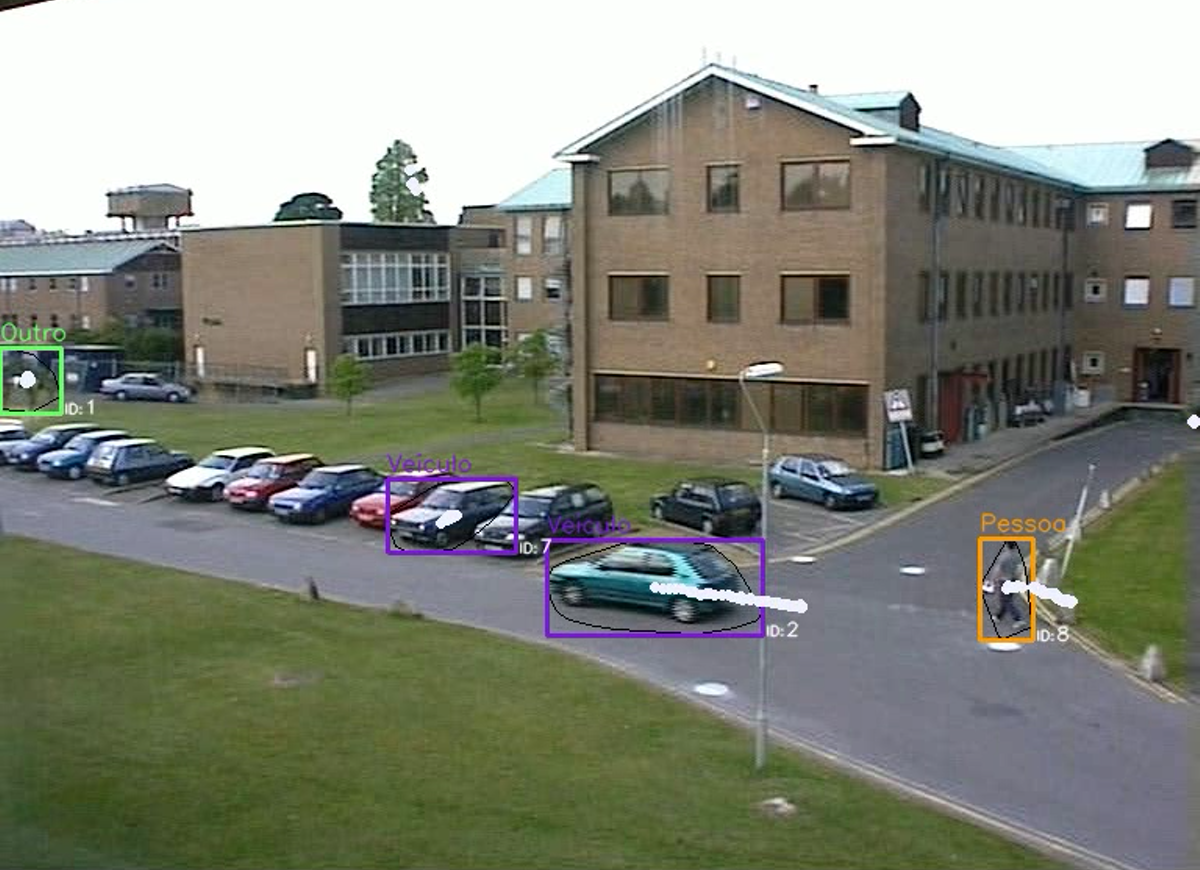

In [14]:
from IPython.display import Image, display

# Specify the path to the image file
image_path = 'exemplo.png'

# Display the image
display(Image(filename=image_path))

Nesta imagem observamos os pontos referidos anteriormente, o contorno da região activa, uma
box a classificar respetivamente o objeto, um identificador e a trajetória nas frames anteriores.

Neste preciso momento conseguimos detetar corretamente as 3 classes distintas no trabalho,
“pessoas”, “veículos” e “outros”.

# 4. Conclusões
<hr style="height:3px"/>

Reconhecendo as imperfeições do produto final, sendo exemplos a dependência ao vídeo em estudo e a falta de consistência de alguns dos valores obtidos por tentativa e erro, concluímos que no contexto presente é suficiente durante maior parte do tempo classificar corretamente um objeto em movimento. Foram consideradas muitas perspetivas diferentes para a concretização do programa que poderiam dar melhores resultados, mas prioritizou-se a mais simples e alinhada com o âmbito da cadeira. Entre essas perspetivas, destacam-se a utilização de algoritmos (tanto "sparse" como "dense") "optical flow" para mais consistentemente seguir as regiões ativas entre frames. Outra vantagem destas perspetivas seria a utilização mais abrangente da matéria lecionada em PIV. Para além disso, a classificação poderia ter sido feita através de um algoritmo mais complexo do que as percentagens de confiança aplicadas aos intervalos de valores observados estaticamente.

Apesar de tudo, com este projeto colocámos à prova as nossas capacidades de programar os conceitos e os conhecimentos adquiridos nas aulas, e conseguimos desenvolver um algoritmo capaz de calcular imagens de fundo, detetar movimento ao longo do tempo e classificar as alterações detetadas.